In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, sampler, Dataset
from sklearn.metrics import roc_curve, auc
import os, time
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
from src.data import *
from src.utils import *
from src.models import *
from torchsummary import summary
from ipywidgets import IntProgress

In [2]:
path_to_saved_model = './saves/'
dir_list = os.listdir(path_to_saved_model)

In [3]:
dir_list

['Conv1d_lr_AvgPool_60.pth',
 'Conv1d_lr_MaxPool_99.pth',
 'Conv1d_lr_MaxPool_80.pth',
 'Conv1d_lr_AvgPool_80.pth']

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
params = {'in_dim': 1, 
          'hidden_dim': 2 ** 10, 
          'out_dim': 1,
          'lr': 1e-3,
          'num_epoch': 100,
         'print_step': 20,
          'device':device}

cpu


In [5]:
df = pd.read_csv('./dataframe.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
train_loader, valid_loader, test_loader = create_dataloader(df)

----- Custom Dataset -----
train data = {'data': array([[0.55287606],
       [0.55287606],
       [0.55277723],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]]), 'target': 1}


In [14]:
pool_type = []
model_list = []
for saved_model in dir_list:
    pooling_type = saved_model.split('_')[2]
    
    if pooling_type == 'MaxPool':
        model = CNN_MaxPool(params['in_dim'], params['hidden_dim'], params['out_dim'])
        
    elif pooling_type == 'AvgPool':
        model = CNN_AvgPool(params['in_dim'], params['hidden_dim'], params['out_dim'])
        
    elif pooling_type == 'MinPool':
        model = CNN_MinPool(params['in_dim'], params['hidden_dim'], params['out_dim'])
    
    model = torch.load(path_to_saved_model + saved_model, map_location=torch.device('cpu'))
    model_list.append(model)
    pool_type.append(pooling_type)

loaded_model = {'pool_type': pool_type, 'model': model_list}
    

In [15]:
loaded_model['pool_type']

['AvgPool', 'MaxPool', 'MaxPool', 'AvgPool']

In [35]:
loaded_model['model'][1].keys()

dict_keys(['epoch', 'model', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'best_auc'])

In [27]:
def plot_comparison(y00, y11, label00, label11, title):
    x_dummy0 = np.linspace(0, len(y0), len(y0))
    x_dummy1 = np.linspace(0, len(y1), len(y1))
    
    plt.plot(x_dummy0, y0, label=label0)
    plt.plot(x_dummy1, y1, label=label1)
    plt.title(title)
    plt.legend()
    plt.show()

In [28]:
loaded_model['pool_type'][0]

'AvgPool'

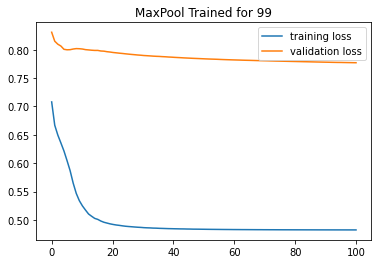

In [30]:
y0 = loaded_model['model'][1]['train_loss']
y1 = loaded_model['model'][1]['val_loss']
t = f'{loaded_model["pool_type"][1]} Trained for {loaded_model["model"][1]["epoch"]}'
plot_comparison(y0, y1, label0='training loss', label1='validation loss', title=t)

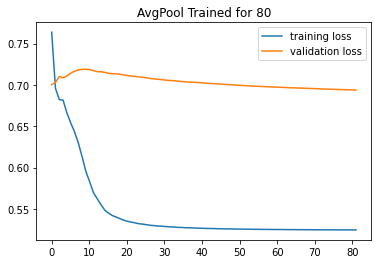

In [32]:
y0 = loaded_model['model'][-1]['train_loss']
y1 = loaded_model['model'][-1]['val_loss']
t = f'{loaded_model["pool_type"][-1]} Trained for {loaded_model["model"][-1]["epoch"]}'
plot_comparison(y0, y1, label0='training loss', label1='validation loss', title=t)

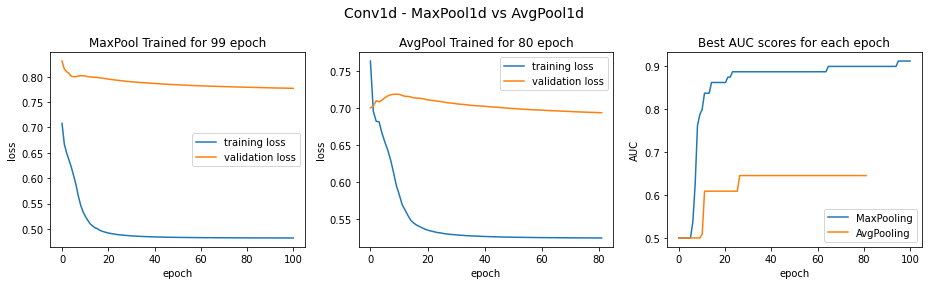

In [46]:
plt.figure(figsize=(13, 4))

## MaxPooling 
plt.subplot(1, 3, 1)
y0 = loaded_model['model'][1]['train_loss']
y1 = loaded_model['model'][1]['val_loss']
x_dummy0 = np.linspace(0, len(y0), len(y0))
plt.plot(x_dummy0, y0, label='training loss')
plt.plot(x_dummy0, y1, label='validation loss')
t = f'{loaded_model["pool_type"][1]} Trained for {loaded_model["model"][1]["epoch"]} epoch'
plt.title(t)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

## AvgPooling
plt.subplot(1, 3, 2)
y0 = loaded_model['model'][-1]['train_loss']
y1 = loaded_model['model'][-1]['val_loss']
x_dummy1 = np.linspace(0, len(y1), len(y1))
plt.plot(x_dummy1, y0, label='training loss')
plt.plot(x_dummy1, y1, label='validation loss')
t = f'{loaded_model["pool_type"][-1]} Trained for {loaded_model["model"][-1]["epoch"]} epoch'
plt.title(t)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

## AUC score
plt.subplot(1, 3, 3)
y0 = loaded_model['model'][1]['best_auc']
y1 = loaded_model['model'][-1]['best_auc']
x_dummy0 = np.linspace(0, len(y0), len(y0))
x_dummy1 = np.linspace(0, len(y1), len(y1))
plt.plot(x_dummy0, y0, label='MaxPooling')
plt.plot(x_dummy1, y1, label='AvgPooling')
t = f'Best AUC scores for each epoch'
plt.title(t)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.legend()

plt.suptitle('Conv1d - MaxPool1d vs AvgPool1d', fontsize=14)
plt.tight_layout()
plt.savefig('./figure/cnn_results.pdf', dpi=300)
plt.show()

In [47]:
max(loaded_model['model'][1]['best_auc']), max(loaded_model['model'][-1]['best_auc'])

(0.9125, 0.6454545454545455)